# **Fase 3: Preparacion de los datos**
## 3.1. Selección de los datos:
Se seleccionan las variables mas importantes tomando en cuenta el analisis previo visto en la fase 2: Conociendo nestros datos





In [3]:
# Librerías base
import pandas as pd
import os
import numpy as np
import warnings

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y escalado
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder

# Desbalanceo
from imblearn.combine import SMOTETomek

# Opcional
warnings.filterwarnings("ignore")

In [4]:
ruta = os.path.join("/content/prediccion-atenciones-medicas-salud-", "data", "dataraw.xlsx")
data = pd.read_excel(ruta)
data.head()

,FECHA_CORTE,ID,DIA_SOLICITACITA,DIA_CITA,ESPECIALIDAD,SEXO,EDAD,SEGURO,PRESENCIAL_REMOTO,ATENDIDO,MONTO
0,20240430,155034,20221220,20230102,GERIATRIA,FEMENINO,77.0,SI,REMOTO,SI,33
1,20240430,612796,20221223,20230102,GASTROENTEROLOGIA,FEMENINO,37.0,SI,PRESENCIAL,SI,7
2,20240430,1576812,20221212,20230102,ENDOCRINOLOGIA,MASCULINO,70.0,NO,PRESENCIAL,SI,7
3,20240430,144470,20221202,20230102,PSIQUIATRIA,FEMENINO,52.0,SI,PRESENCIAL,SI,30
4,20240430,931190,20221219,20230102,CARDIOLOGIA,FEMENINO,56.0,SI,PRESENCIAL,SI,7


In [5]:
data.columns

Index(['FECHA_CORTE', 'ID', 'DIA_SOLICITACITA', 'DIA_CITA', 'ESPECIALIDAD',
       'SEXO', 'EDAD', 'SEGURO', 'PRESENCIAL_REMOTO', 'ATENDIDO', 'MONTO'],
      dtype='object')

In [6]:
#3.1. Seleccion de variables
data1 = data.iloc[:, 2:11]
data1 = data1.drop(['SEXO'],axis=1)
data1.head()

,DIA_SOLICITACITA,DIA_CITA,ESPECIALIDAD,EDAD,SEGURO,PRESENCIAL_REMOTO,ATENDIDO,MONTO
0,20221220,20230102,GERIATRIA,77.0,SI,REMOTO,SI,33
1,20221223,20230102,GASTROENTEROLOGIA,37.0,SI,PRESENCIAL,SI,7
2,20221212,20230102,ENDOCRINOLOGIA,70.0,NO,PRESENCIAL,SI,7
3,20221202,20230102,PSIQUIATRIA,52.0,SI,PRESENCIAL,SI,30
4,20221219,20230102,CARDIOLOGIA,56.0,SI,PRESENCIAL,SI,7


## 3.2. Limpieza de los datos

1.   **Corrección de tipos de datos:**

  * La variable ATENDIDO se convierte de valores categóricos ("SI"/"NO") a binarios (1/0).
  * Las columnas de fechas (DIA_SOLICITACITA y DIA_CITA) se transforman al tipo datetime para facilitar operaciones temporales.
  * Variables categóricas como ESPECIALIDAD, SEGURO, PRESENCIAL_REMOTO y MONTO se convierten al tipo category, optimizando memoria y análisis.


2.   **Eliminación de datos inconsistentes:**

  * Se filtran únicamente las especialidades con al menos 365 registros, asegurando representatividad en el análisis.
  * Se eliminan registros con valores nulos en EDAD y SEGURO.
  * La variable EDAD se transforma a valores absolutos para corregir posibles registros negativos.
  * Finalmente, se reinicia el índice del dataset para mantener la estructura ordenada.


In [7]:
#3.2. Corregir tipos de datos
def corregir_tipos_de_datos(data1):

  col1 = ['DIA_SOLICITACITA', 'DIA_CITA']
  col2 = ['ESPECIALIDAD', 'SEGURO', 'PRESENCIAL_REMOTO','MONTO']

  # Convetir 'SI' y 'NO' a 1 y 0
  if 'ATENDIDO' in data1.columns:
    data1['ATENDIDO']= data1['ATENDIDO'].map({'SI':1, 'NO':0})
  # Convertir columnas de fecha a tipo datatime
  for col in col1:
    if col in data.columns:
      data1[col]= pd.to_datetime(data1[col].astype(str), errors="coerce")
  for col in col2:
    if col in data.columns:
      data1[col]= data1[col].astype('category')

  return data1

data1 = corregir_tipos_de_datos(data1)

In [8]:
#3.2. Eliminamos datos inconsistentes
def limpiar_datos(data1):
  # filtrar especialidades frecuentes
  data1 = data1[data1['ESPECIALIDAD'].map(data1['ESPECIALIDAD'].value_counts()) >= 365]
  #Eliminar nulos
  data1 = data1.dropna(subset=['EDAD','SEGURO'])
  # Edad a valor absoluto
  data1['EDAD']= data['EDAD'].abs()
  # Reiniciar indice
  return data1.reset_index(drop=True)

data1 = limpiar_datos(data1)

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450136 entries, 0 to 450135
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DIA_SOLICITACITA   450136 non-null  datetime64[ns]
 1   DIA_CITA           450136 non-null  datetime64[ns]
 2   ESPECIALIDAD       450136 non-null  category      
 3   EDAD               450136 non-null  float64       
 4   SEGURO             450136 non-null  category      
 5   PRESENCIAL_REMOTO  450136 non-null  category      
 6   ATENDIDO           450136 non-null  int64         
 7   MONTO              450136 non-null  category      
dtypes: category(4), datetime64[ns](2), float64(1), int64(1)
memory usage: 15.5 MB


## 3.3. Construccion de variables

1. **Creación de variables derivadas de fecha:**

  * Se calcula Diferencia_dias, que mide el tiempo entre la solicitud y la cita.
  * Se extraen componentes temporales: mes_cita, semana_mes_cita, bimestre_cita, trimestre_cita y semestre_cita.
  * Se genera la variable Cita_mes_diferente, que indica si la cita ocurrió en un mes distinto al de la solicitud.
  * Se determina la estacion_cita (verano, otoño, invierno, primavera) y se codifica en valores numéricos.

2. **Análisis de correlaciones:**

  * Se construye un mapa de calor para evaluar la relación entre las nuevas variables y las existentes.
  * Esto permite identificar dependencias útiles para el modelado y selección de atributos.

3. **Conversión de variables a categóricas:**

  * Las nuevas variables derivadas se convierten al tipo category.

4. **Validación y limpieza de Diferencia_dias:**

  * Se describen estadísticamente los valores de la variable.
  * Se eliminan registros con valores negativos (citas antes de la solicitud).
  * Se reinicia el índice para mantener la estructura ordenada.

5. **Reselección de variables:**

  * Se seleccionan las columnas más relevantes, incluyendo las nuevas variables derivadas.
  * Se conforma un dataset más compacto y listo para análisis posteriores.

In [10]:
#3.3. Crear variables derivadas de fecha
def crear_variables(data1):
    """
    Crea variables derivadas de fechas para análisis.
    Requiere columnas 'DIA_CITA' y 'DIA_SOLICITACITA' en formato datetime.

    - DIFERENCIA_DIAS: días entre solicitud y cita
    - mes_cita: mes de la cita
    - estacion_cita: estación del año (hemisferio sur), convertida a entero
    - semana_mes_cita: semana del mes (1 a 5)
    - bimestre_cita: bimestre del año (1 a 6)
    - trimestre_cita: trimestre del año (1 a 4)
    - Cita_mes_diferente: 1 si el mes de cita es distinto al de solicitud
    - semestre_cita: semestre del año (1 o 2)
    """

    def obtener_estacion(fecha):
        año = fecha.year
        if pd.Timestamp(f'{año}-12-21') <= fecha or fecha < pd.Timestamp(f'{año}-3-21'):
            return 'verano'
        elif pd.Timestamp(f'{año}-3-21') <= fecha < pd.Timestamp(f'{año}-6-21'):
            return 'otoño'
        elif pd.Timestamp(f'{año}-6-21') <= fecha < pd.Timestamp(f'{año}-9-23'):
            return 'invierno'
        else:
            return 'primavera'

    # Calcular diferencia en días
    data1['Diferencia_dias'] = (data1['DIA_CITA'] - data1['DIA_SOLICITACITA']).dt.days

    # Extraer componentes de fecha
    data1['mes_cita'] = data1['DIA_CITA'].dt.month
    data1['semana_mes_cita'] = (data1['DIA_CITA'].dt.day.sub(1) // 7) + 1
    data1['bimestre_cita'] = ((data1['DIA_CITA'].dt.month - 1) // 2) + 1
    data1['trimestre_cita'] = ((data1['DIA_CITA'].dt.month - 1) // 3) + 1
    data1['semestre_cita'] = ((data1['DIA_CITA'].dt.month - 1) // 6) + 1
    data1['Cita_mes_diferente'] = (data1['DIA_SOLICITACITA'].dt.month != data1['DIA_CITA'].dt.month).astype(int)

    # Estación del año y codificación
    data1['estacion_cita'] = data1['DIA_CITA'].apply(obtener_estacion)
    data1['estacion_cita'] = pd.factorize(data1['estacion_cita'])[0]

    return data1

data1 = crear_variables(data1)


In [11]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450136 entries, 0 to 450135
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   DIA_SOLICITACITA    450136 non-null  datetime64[ns]
 1   DIA_CITA            450136 non-null  datetime64[ns]
 2   ESPECIALIDAD        450136 non-null  category      
 3   EDAD                450136 non-null  float64       
 4   SEGURO              450136 non-null  category      
 5   PRESENCIAL_REMOTO   450136 non-null  category      
 6   ATENDIDO            450136 non-null  int64         
 7   MONTO               450136 non-null  category      
 8   Diferencia_dias     450136 non-null  int64         
 9   mes_cita            450136 non-null  int32         
 10  semana_mes_cita     450136 non-null  int32         
 11  bimestre_cita       450136 non-null  int32         
 12  trimestre_cita      450136 non-null  int32         
 13  semestre_cita       450136 no

<Axes: >

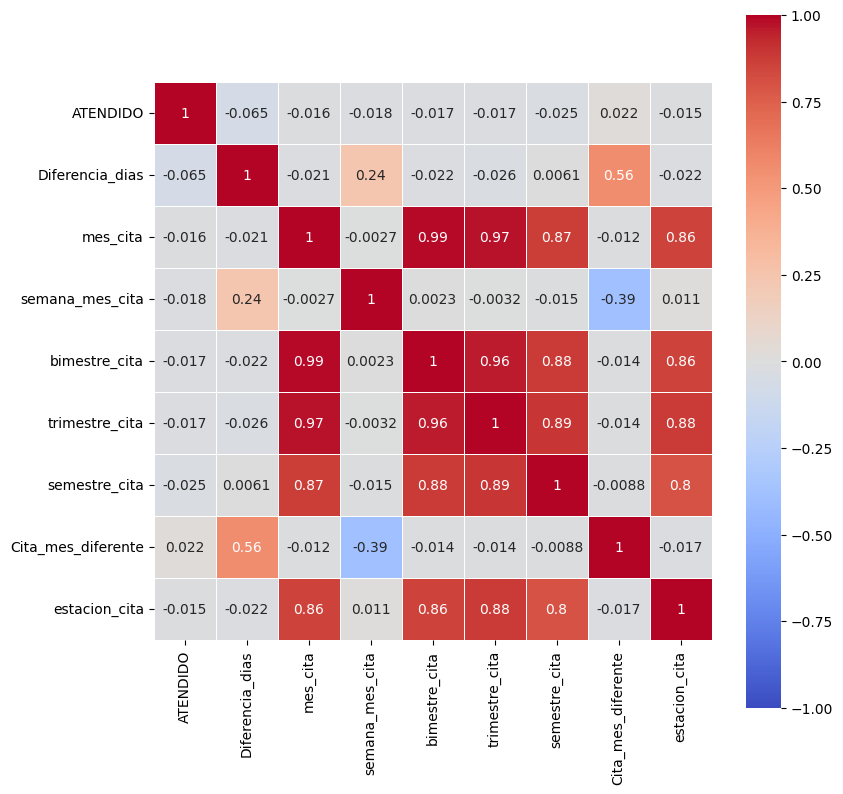

In [12]:
#3.3. Correlacion con las nuevas variables
v_numericas5 = data1.iloc[:, [6] + list(range(8,16))]
correlaciones2 = v_numericas5.corr()
f, ax = plt.subplots(figsize=(9,9))
sns.heatmap(correlaciones2,cmap="coolwarm",vmin=-1,vmax=1,
            linewidths=.5,square=True,annot=True)

In [13]:
#3.3. Los convertimos a categoricas
cols= data1.columns[[7] + list(range(9,16))]
data1[cols] = data1[cols].astype('category')

# Verificar los tipos de datos actualizados
#data1.info()

# Descripcion de la nueva variable incluida
data1['Diferencia_dias'].describe()

,Diferencia_dias
count,450136.000000
mean,19.814940
std,12.777777
min,-1.000000
25%,9.000000
50%,17.000000
75%,28.000000
max,89.000000


In [14]:
#3.3. Filtrar los valores negativos
df_diasn = data1[data1['Diferencia_dias'] < 0]
df_diasn

,DIA_SOLICITACITA,DIA_CITA,ESPECIALIDAD,EDAD,SEGURO,PRESENCIAL_REMOTO,ATENDIDO,MONTO,Diferencia_dias,mes_cita,semana_mes_cita,bimestre_cita,trimestre_cita,semestre_cita,Cita_mes_diferente,estacion_cita
107700,2023-03-31,2023-03-30,SALUD MENTAL,30.0,SI,REMOTO,0,33,-1,3,5,2,1,1,0,1
107750,2023-03-31,2023-03-30,SALUD MENTAL,23.0,SI,REMOTO,0,33,-1,3,5,2,1,1,0,1
132970,2023-04-21,2023-04-20,SALUD MENTAL,41.0,SI,REMOTO,0,33,-1,4,3,2,2,1,0,1
417362,2023-12-05,2023-12-04,OTORRINOLARINGOLOGIA,61.0,NO,PRESENCIAL,1,7,-1,12,1,6,4,2,0,3


In [15]:
#3.3. Limpieza de la nueva variable
def limpiar_diferencia_dias(data1):
    return data1[data1['Diferencia_dias'] >= 0].reset_index(drop=True)

data1 = limpiar_diferencia_dias(data1)


In [16]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450132 entries, 0 to 450131
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   DIA_SOLICITACITA    450132 non-null  datetime64[ns]
 1   DIA_CITA            450132 non-null  datetime64[ns]
 2   ESPECIALIDAD        450132 non-null  category      
 3   EDAD                450132 non-null  float64       
 4   SEGURO              450132 non-null  category      
 5   PRESENCIAL_REMOTO   450132 non-null  category      
 6   ATENDIDO            450132 non-null  int64         
 7   MONTO               450132 non-null  category      
 8   Diferencia_dias     450132 non-null  int64         
 9   mes_cita            450132 non-null  category      
 10  semana_mes_cita     450132 non-null  category      
 11  bimestre_cita       450132 non-null  category      
 12  trimestre_cita      450132 non-null  category      
 13  semestre_cita       450132 no

In [17]:
#3.3. ReSeleccionar las variables

df_iloc = data1.iloc[:, 2:9]
df_names = data1[['semestre_cita', 'Cita_mes_diferente','semana_mes_cita']]
data1 = pd.concat([df_iloc, df_names], axis=1)


## 3.4. Formateo de datos

1. **Escalamiento de variables numéricas:**

  * Se seleccionan las variables numéricas y se aplica StandardScaler para normalizar su distribución.
  * Este proceso asegura que todas las variables tengan la misma escala, evitando que unas dominen sobre otras en los modelos.

2. **Codificación de variables categóricas:**

  * Se identifican las columnas de tipo categórico y se transforman mediante OrdinalEncoder.
  * Se asignan valores numéricos a cada categoría, manejando valores desconocidos con un código especial (-1).

3. **Tratamiento del desbalance de clases:**

  * Se aplica la técnica SMOTETomek, que combina sobremuestreo de la clase minoritaria y limpieza de ruido.
  * El resultado es un dataset balanceado en la variable objetivo (ATENDIDO), mejorando la calidad del entrenamiento.

In [18]:
#3.4. Escalamiento de variables numericas
v_numericos = data1.select_dtypes([int,float]).drop(['ATENDIDO'],axis=1)
#v_numericos_minmax = pd.DataFrame(MinMaxScaler().fit_transform(v_numericos), columns=v_numericos.columns)
v_numericas_std = pd.DataFrame(StandardScaler().fit_transform(v_numericos), columns=v_numericos.columns)

#3.4. Codificamos las varibles de texto
v_dum = data1.select_dtypes(["category"])
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
v_dum_encoded = pd.DataFrame(encoder.fit_transform(v_dum),
                            columns=v_dum.columns,
                            index=v_dum.index)


In [19]:
#3.4. Concatenamos el escalamiento y cadificacion
data2 = pd.concat([v_numericas_std,v_dum_encoded],axis=1)
data2.shape

(450132, 9)

In [20]:
X = data2.values.astype('float32')
y = data1['ATENDIDO']
y.unique()

array([1, 0])

In [21]:
#3.4. Tratamineto de desvalance de clases mediante SMOTETomek
X_bal, y_bal = SMOTETomek(sampling_strategy="minority", n_jobs=-1).fit_resample(X, y)

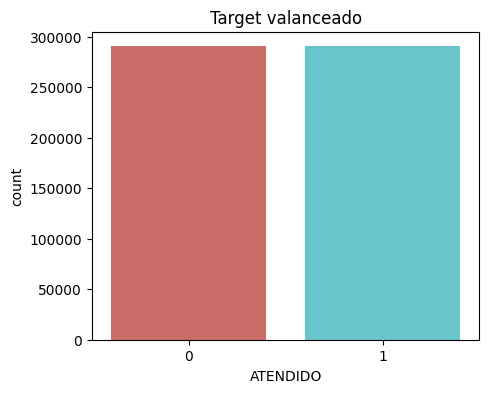

ATENDIDO
1    290241
0    290241
Name: count, dtype: int64


In [22]:
plt.figure(figsize=(5,4))
sns.countplot(x=y_bal, palette="hls")
plt.title('Target valanceado')
plt.show()
print(y_bal.value_counts())

In [23]:
# Dataframe de la data transformada
data3 = pd.concat([pd.DataFrame(X_bal, columns=data2.columns), pd.DataFrame(y_bal, columns=['ATENDIDO'])], axis=1)

In [24]:
# Exportamos data3 en csv y excel
# data3.to_csv('data_transf.csv', index=False)
# data3.to_excel('data_transf.xlsx', index=False)